# Clasificación de géneros musicales

En los últimos años, los servicios de streaming con grandes catálogos se han convertido en el medio principal a través del cual la mayoría de las personas escuchan su música favorita. Pero al mismo tiempo, la gran cantidad de música que se ofrece puede hacer que los usuarios se sientan un poco abrumados al intentar buscar música más nueva que se adapte a sus gustos.

Por esta razón, los servicios de streaming han buscado formas de categorizar la música para permitir recomendaciones personalizadas. Un método implica el análisis directo de la información de audio sin procesar en una canción determinada, puntuando los datos sin procesar en una variedad de métricas. En este proyecto, examinaremos datos compilados por un grupo de investigación conocido como The Echo Nest. Nuestro objetivo es analizar este conjunto de datos y clasificar las canciones como 'Hip-Hop' o 'Rock', todo sin escuchar ni una sola canción. Al hacerlo, aprenderemos cómo limpiar nuestros datos, hacer una visualización exploratoria de datos y usar la reducción de características para el objetivo de alimentar nuestros algunos algoritmos simples de aprendizaje automático, como árboles de decisión y regresión logística.

## 1. Preparación del conjunto de datos

In [53]:
#Bibliotecas#
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
import time

Para empezar, carguemos los metadatos sobre las canciones junto con las métricas las canciones presentes en el conjunto de datos obtenido por The Echo Nest. Una canción es más que su título, artista y número de reproducciones. Tenemos otro conjunto de datos que tiene características musicales de cada pista, como la bailabilidad y la acústica en una escala de -1 a 1. Estos existen en dos archivos diferentes, que están en diferentes formatos: CSV y JSON. Si bien CSV es un formato de archivo popular para denotar datos tabulares, JSON es otro formato de archivo común en el que las bases de datos a menudo devuelven los resultados de una consulta determinada.

Comencemos creando dos DataFrames de pandas a partir de estos archivos que podamos fusionar para que tengamos características y etiquetas (a menudo también denominadas X e y) para la clasificación más adelante.

In [2]:
TRACKS_METADATA_PATH = './Data/fma-rock-vs-hiphop.csv'
TRACKS_METRICS_PATH = './Data/echonest-metrics.json'

In [3]:
# Lectura de metadatos de las canciones y su género
tracks = pd.read_csv(TRACKS_METADATA_PATH)

# Lectura de métricas de las canciones
echonest_metrics = pd.read_json(TRACKS_METRICS_PATH)

# Combinación de metadatos y métricad de las canciones
echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']],on='track_id')

# Visualización del dataframe
echo_tracks.head(10)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock
5,154,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632,Rock
6,155,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325,Rock
7,169,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347,Rock
8,170,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548,Rock
9,171,0.698278,0.285816,0.213494,0.955691,0.087036,0.064094,125.645,0.150599,Rock


## 2. Búsqueda de relaciones entre pares de variables

Por lo general, queremos evitar el uso de características que tienen fuertes correlaciones entre sí, evitando así la redundancia de funciones, por algunas razones:
<ul>
<li> Para mantener el modelo simple y mejorar la interpretabilidad (con muchas características, corremos el riesgo de sobreajuste). </li>
<li> Cuando nuestros conjuntos de datos son muy grandes, usar menos características puede acelerar drásticamente nuestro tiempo de cálculo. </li>
</ul>
<p> Para tener una idea de si hay características fuertemente correlacionadas en nuestros datos, usaremos funciones integradas en la biblioteca pandas. </p>

In [4]:
# Creación de matriz de correlación
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


## 3. Normalización de características

Como se mencionó anteriormente, puede ser particularmente útil simplificar nuestros modelos y utilizar la menor cantidad de funciones que sean necesarias para lograr el mejor resultado. Dado que no encontramos ninguna correlación fuerte en particular entre nuestras características, podemos utilizar un enfoque común para reducir la cantidad de características llamado análisis de componentes principales (PCA).

Es posible que la variación entre los géneros se pueda explicar por unas pocas características en el conjunto de datos. PCA rota los datos a lo largo del eje de mayor varianza, lo que nos permite determinar la contribución relativa de cada característica de nuestros datos hacia la varianza entre clases.

Sin embargo, dado que PCA usa la varianza absoluta de una característica para rotar los datos, una característica con un rango más amplio de valores dominará y sesgará el algoritmo en relación con las otras características. Para evitar esto, primero debemos normalizar nuestros datos. Hay algunos métodos para hacer esto, pero una forma común es a través de la estandarización, de modo que todas las características tengan una media = 0 y una desviación estándar = 1 (la resultante es una puntuación z).

In [5]:
# Obtención de características
features = [feature for feature in echo_tracks.columns if feature not in ['track_id', 'genre_top']]

# Obtención de etiquetas
labels = echo_tracks['genre_top']

# Normalización mediante StandardScaler
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(echo_tracks[features])

## 4. Reducción de dimensionalidad mediante PCA

Ahora que hemos normalizado nuestros datos, estamos listos para usar PCA para determinar cuánto podemos reducir la dimensionalidad de nuestros datos. Podemos la gráfica de la varianza explicada acumulativa para encontrar el número de componentes que se utilizarán en análisis posteriores.

La gráfica muestra el número de componentes frente a la varianza explicada por cada componente, ordenados en orden descendente de varianza. Las gráficas nos ayudan a tener una mejor idea de qué componentes explican una cantidad suficiente de varianza en nuestros datos. Cuando se utilizan gráficos de barras, normalmente se utiliza un 'codo' (una caída pronunciada de un punto de datos al siguiente) en el gráfico para decidir el límite apropiado.

Text(0.5, 0, 'Principal Component #')

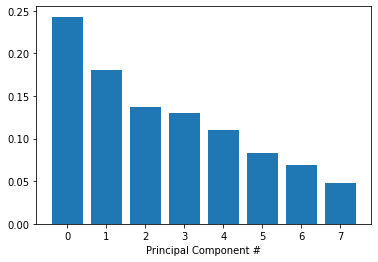

In [9]:
%matplotlib inline

# Obtención de varianza explicada
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_ 

# gráfica de varianza explicada
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

Desafortunadamente, no parece haber un codo claro en este diagrama de bloques, lo que significa que no es sencillo encontrar el número de dimensiones intrínsecas usando este método.

En su lugar, también podemos observar la gráfica de varianza explicada acumulativa para determinar cuántas características se requieren para explicar, digamos, aproximadamente el 85% de la varianza (los puntos de corte son algo arbitrarios aquí y, por lo general, se deciden mediante 'reglas generales'). Una vez que determinamos el número apropiado de componentes, podemos realizar PCA con esa cantidad de componentes, idealmente reduciendo la dimensionalidad de nuestros datos.

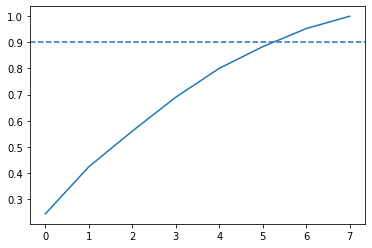

In [10]:
# Varianza explicada acumulada
cum_exp_variance = np.cumsum(exp_variance)

# Gráfica de varianza explicada acumulada, dibujando una línea en 0.9
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
### Finding indice where cum_exp_variance exceeds 0.9 and adding 1 to that indice to get n_components
n_components = ((np.where(cum_exp_variance > 0.9))[0][0]) 


# Ejecución de PCA con el número de componentes elegido mediante la gráfica de varianza acumulada explicada
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

## 5. Entrenamiento de un árbol de decisión

Ahora podemos usar la proyección PCA de menor dimensión de los datos para clasificar las canciones en géneros. Para hacer eso, primero necesitamos dividir nuestro conjunto de datos en subconjuntos de entrenamiento y prueba, donde el subconjunto de entrenamiento se usará para entrenar nuestro modelo, mientras que el conjunto de datos de prueba permite la validación del rendimiento del modelo.

Aquí, usaremos un algoritmo simple conocido como árbol de decisión. Los árboles de decisión son clasificadores basados en reglas que incorporan características y siguen una 'estructura de árbol' de decisiones binarias para clasificar en última instancia un punto de datos en una de dos o más categorías. Además de ser fáciles de usar e interpretar, los árboles de decisión nos permiten visualizar el 'diagrama de flujo lógico' que genera el modelo a partir de los datos de entrenamiento.

In [11]:
# División de datos en entrenamiento y prueba
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels,random_state=10)

# Entrenamiento
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features,train_labels)

# Predicciones
pred_labels_tree = tree.predict(test_features)

## 6. Comparación con Regresión logística

Aunque el rendimiento de nuestro árbol es decente, es una mala idea asumir de inmediato que, por lo tanto, es la herramienta perfecta para este trabajo. Siempre es una buena idea probar al menos algunos otros algoritmos y encontrar el que sea mejor para nuestros datos.

A veces, lo más simple es lo mejor, por lo que comenzaremos aplicando regresión logística. La regresión logística utiliza lo que se llama función logística para calcular las probabilidades de que un punto de datos determinado pertenezca a una clase determinada

In [12]:
#Clasificador serial#
logreg = linear_model.LogisticRegression(C=0.01, random_state=10)
print("Serial")
%timeit logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("\nDecision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Serial
7.13 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.51      0.62       235
        Rock       0.89      0.97      0.93       966

    accuracy                           0.88      1201
   macro avg       0.84      0.74      0.77      1201
weighted avg       0.87      0.88      0.87      1201



## 7. Utilización del backend de Dask con Sci-kit learn

In [32]:
from dask.distributed import Client
import dask.dataframe as dd
import dask
import joblib
from sklearn import preprocessing
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA
from dask_ml.model_selection import train_test_split

In [16]:
client = Client()

In [17]:
client

Client Scheduler: tcp://127.0.0.1:50217 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


### 7.1 Preparacion del dataset

In [18]:
# Lectura de metadatos
tracks = pd.read_csv(TRACKS_METADATA_PATH)

# Lectura de métricas
echonest_metrics = pd.read_json(TRACKS_METRICS_PATH)

# Combinación de metadatos y métricas
echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']],on='track_id')

# Visualización de datos
echo_tracks.head(10)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock
5,154,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632,Rock
6,155,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325,Rock
7,169,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347,Rock
8,170,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548,Rock
9,171,0.698278,0.285816,0.213494,0.955691,0.087036,0.064094,125.645,0.150599,Rock


In [21]:
encoder = preprocessing.LabelEncoder()

In [22]:
# Codificación de clases
echo_tracks['genre_top'] = echo_tracks[['genre_top']].apply(encoder.fit_transform)

In [23]:
echo_tracks = dd.from_pandas(echo_tracks, chunksize=100)

In [24]:
echo_tracks.head(10)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,0
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,0
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,0
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,0
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,1
5,154,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632,1
6,155,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325,1
7,169,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347,1
8,170,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548,1
9,171,0.698278,0.285816,0.213494,0.955691,0.087036,0.064094,125.645,0.150599,1


### 7.2 Relaciones entre pares de variables

In [25]:
# Matriz de correlación
corr_metrics = echo_tracks.corr().compute()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070,-0.004624
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841,0.097748
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165,-0.484457
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603,0.124860
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967,0.326037
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093,-0.007070
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894,-0.496495
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221,0.114571
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000,-0.246701
genre_top,-0.004624,0.097748,-0.484457,0.124860,0.326037,-0.007070,-0.496495,0.114571,-0.246701,1.000000


### 7.3 Normalización de datos

In [27]:
# Definición de características
features = [feature for feature in echo_tracks.columns if feature not in ['track_id', 'genre_top']]

# Definición de etiquetas
labels = echo_tracks['genre_top']

# Normalización de características
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(echo_tracks[features])

### 7.4 Reducción de dimensionalidad don PCA

In [29]:
scaled_train_features = scaled_train_features.to_dask_array(lengths=True)

Text(0.5, 0, 'Principal Component #')

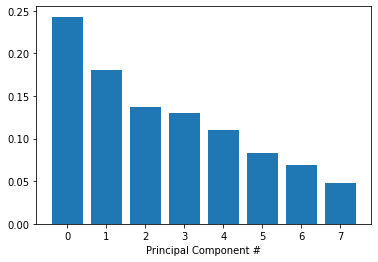

In [30]:
%matplotlib inline

# Obtener varianza explicada
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_ 

# Gráfica de varianza explicada
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

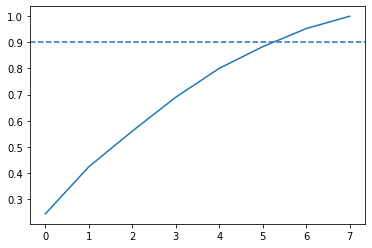

In [31]:
# Calculo de varianza explicada acumulada
cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
# Obtener el número de componentes cuando la varianza explicada acumulada excede el 0.9
n_components = ((np.where(cum_exp_variance > 0.9))[0][0]) 


# Ejecución de PCA con el número de componentes cuando la varianza explicada acumulada excede el 0.9
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

### 7.5 Entrenamiento de regresión logística mediante Backend de Dask

In [33]:
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels,random_state=10, convert_mixed_types=True)

In [34]:
logreg = linear_model.LogisticRegression(C=0.01, random_state=10, verbose=1)

In [35]:
from sklearn.utils import parallel_backend

In [37]:
with parallel_backend('dask'):
    %timeit logreg.fit(train_features, train_labels)
    predictions = logreg.predict(test_features)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


## 8. Entrenamiento de regresión logística mediante Dask_ML

In [38]:
from dask_ml.linear_model import LogisticRegression as dask_lr

In [39]:
logreg = dask_lr(C=0.01, random_state=10, verbose=1)

In [40]:
%timeit logreg.fit(train_features, train_labels)

1min 38s ± 44.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 9. Implementación Propia de Regresión logística

In [54]:
from hklearn import LogisticRegression

In [55]:
# Lectura de metadatos de las canciones y su género
tracks = pd.read_csv(TRACKS_METADATA_PATH)

# Lectura de métricas de las canciones
echonest_metrics = pd.read_json(TRACKS_METRICS_PATH)

# Combinación de metadatos y métricad de las canciones
echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']],on='track_id')


In [56]:
# Obtención de características
features = [feature for feature in echo_tracks.columns if feature not in ['track_id', 'genre_top']]

# Obtención de etiquetas
labels = echo_tracks['genre_top']

# Normalización mediante StandardScaler
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(echo_tracks[features])

In [57]:
# Obtención de varianza explicada
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_ 

In [58]:
# Varianza explicada acumulada
cum_exp_variance = np.cumsum(exp_variance)
# Ejecución de PCA con el número de componentes elegido mediante la gráfica de varianza acumulada explicada
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [59]:
logistic_model_s = LogisticRegression(C = 0.01, maxiter = 100, solver = 'lbfgs')

In [60]:
features = [feature for feature in echo_tracks.columns if feature not in ['track_id', 'genre_top']]

labels = echo_tracks['genre_top']

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(echo_tracks[features])

pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [61]:
# División de datos
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels,random_state=10)

In [62]:
print("Serial")
%timeit logistic_model_s.fit(train_features, train_labels)
y_pred = logistic_model_s.predict(test_features)

Serial
4.04 ms ± 44.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
print("Logistic Regression: \n", classification_report(test_labels, y_pred))

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.51      0.62       235
        Rock       0.89      0.97      0.93       966

    accuracy                           0.88      1201
   macro avg       0.84      0.74      0.77      1201
weighted avg       0.87      0.88      0.87      1201



## 10. Uso de Numba en implementación propia de Regresion Logística

In [66]:
from hklearnNumba import LogisticRegression

In [71]:
tracks = pd.read_csv(TRACKS_METADATA_PATH)

echonest_metrics = pd.read_json(TRACKS_METRICS_PATH)

echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']],on='track_id')

echo_tracks.head(10)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock
5,154,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632,Rock
6,155,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325,Rock
7,169,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347,Rock
8,170,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548,Rock
9,171,0.698278,0.285816,0.213494,0.955691,0.087036,0.064094,125.645,0.150599,Rock


In [72]:
encoder = preprocessing.LabelEncoder()

In [73]:
echo_tracks['genre_top'] = echo_tracks[['genre_top']].apply(encoder.fit_transform)

In [74]:
echo_tracks.head(10)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,0
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,0
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,0
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,0
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,1
5,154,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632,1
6,155,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325,1
7,169,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347,1
8,170,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548,1
9,171,0.698278,0.285816,0.213494,0.955691,0.087036,0.064094,125.645,0.150599,1


In [75]:
features = [feature for feature in echo_tracks.columns if feature not in ['track_id', 'genre_top']]

labels = echo_tracks['genre_top']

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(echo_tracks[features])

In [ ]:
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_ 

cum_exp_variance = np.cumsum(exp_variance)

pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [76]:
logistic_model_s = LogisticRegression(C = 0.01, maxiter = 100, solver = 'lbfgs')

In [77]:
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels,random_state=10)

In [78]:
print("Serial")
%timeit logistic_model_s.fit(train_features, train_labels, train_features.shape[1],train_features.shape[0])

Serial
2.91 ms ± 62.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
#y_pred = logistic_model_s.predict(test_features)